<a href="https://colab.research.google.com/github/TheBlock98/Thesis/blob/main/Model/hybridCNNLSTM24h_L1L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



```
HybridModelFCLSTM(
  (hybridNetwork): Sequential(
    (0): Linear(in_features=61, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): LSTM(200, 200, dropout=0.3)
  )
  (endLinearLayer): Linear(in_features=200, out_features=24, bias=True)
)

```



Stock Market Forecasting Neural Networks for Multi-Output Regression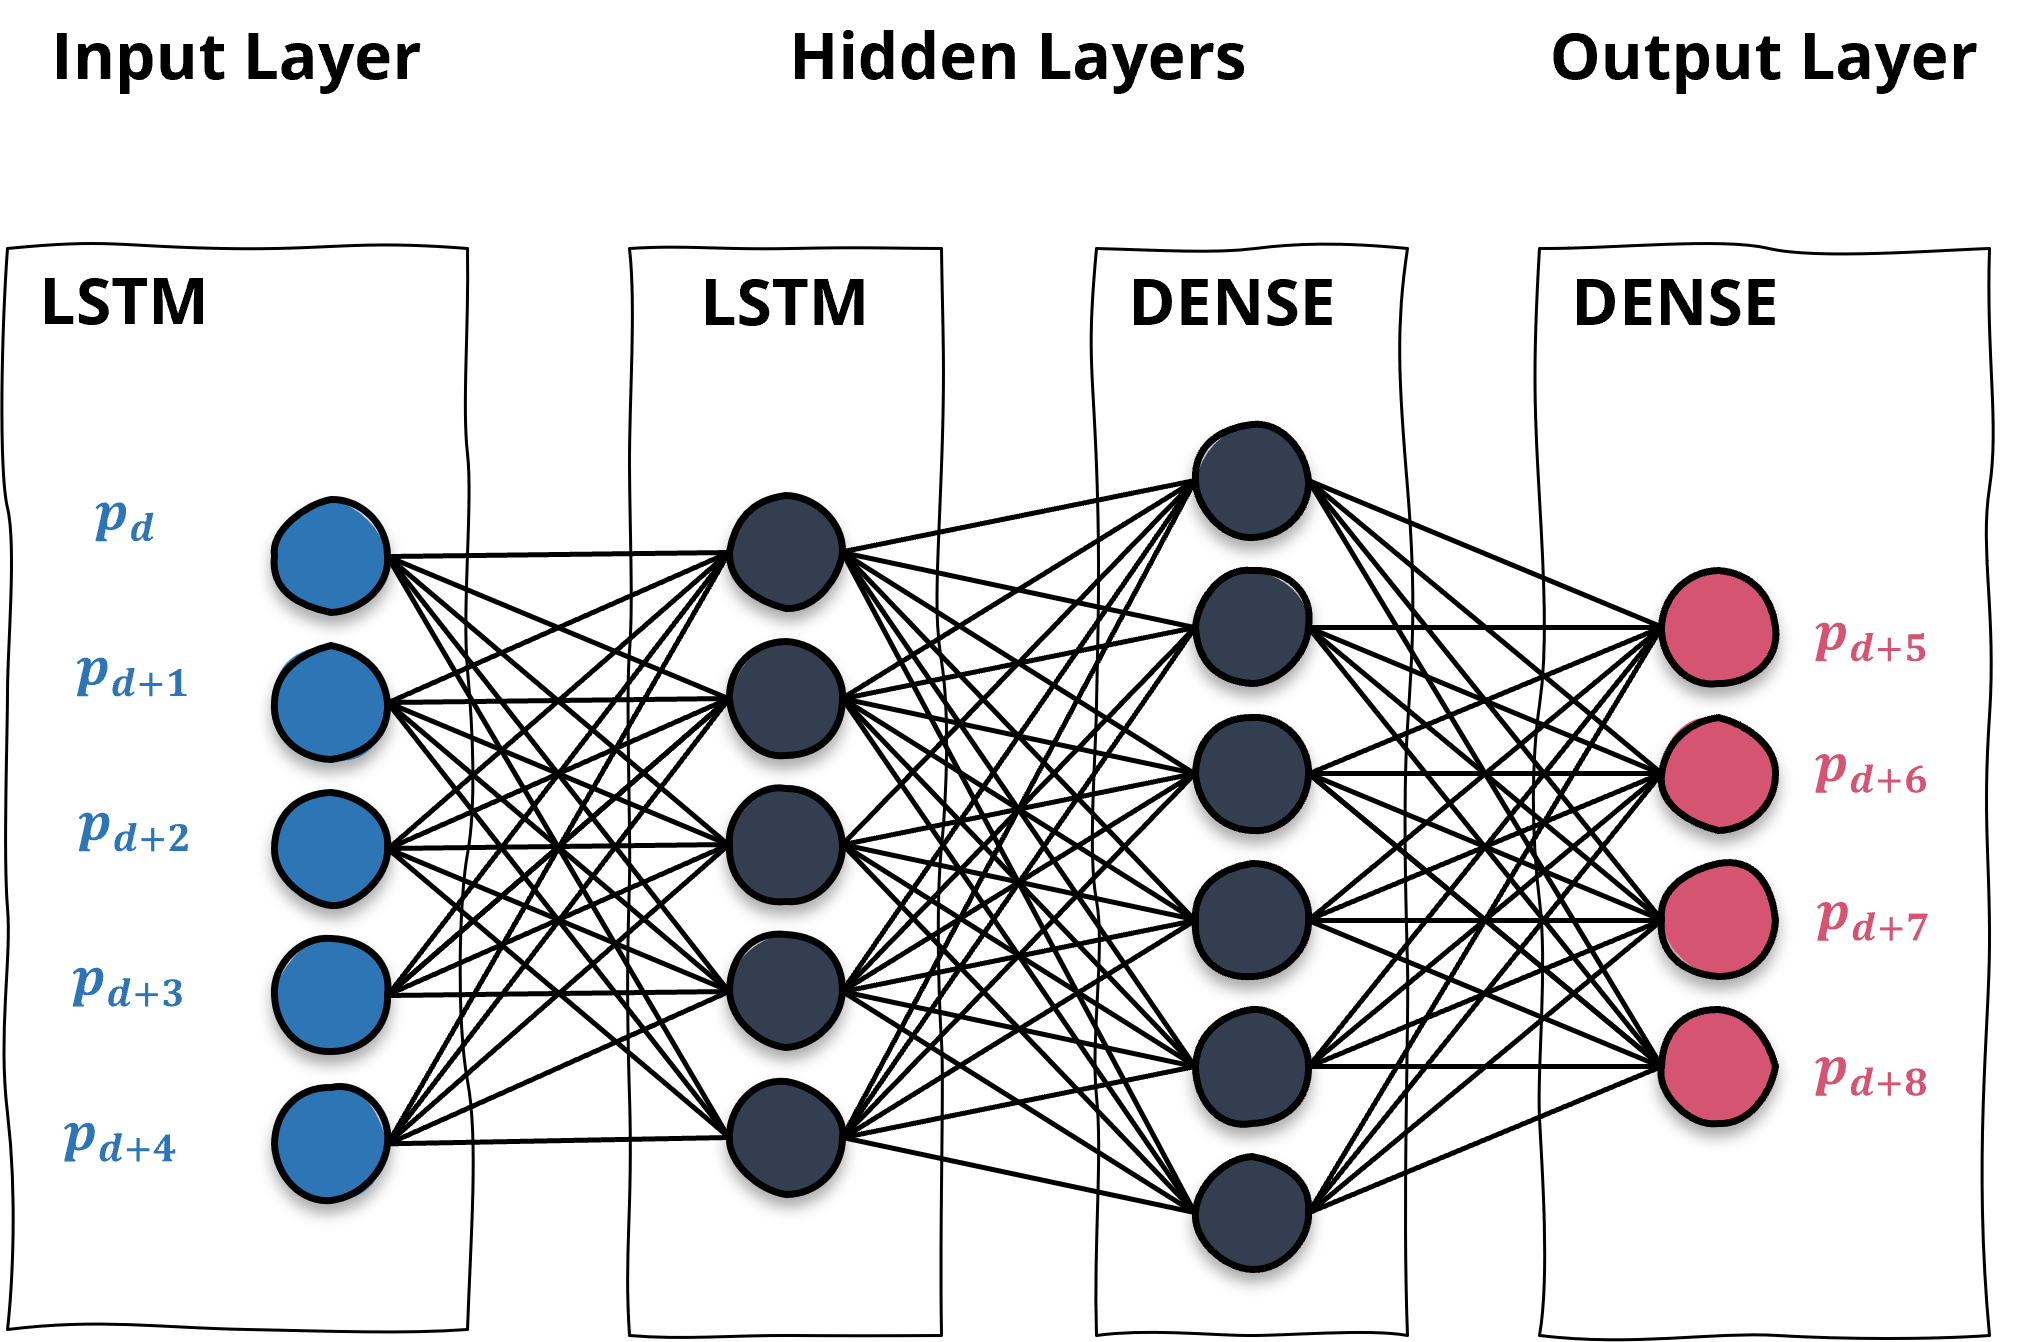



d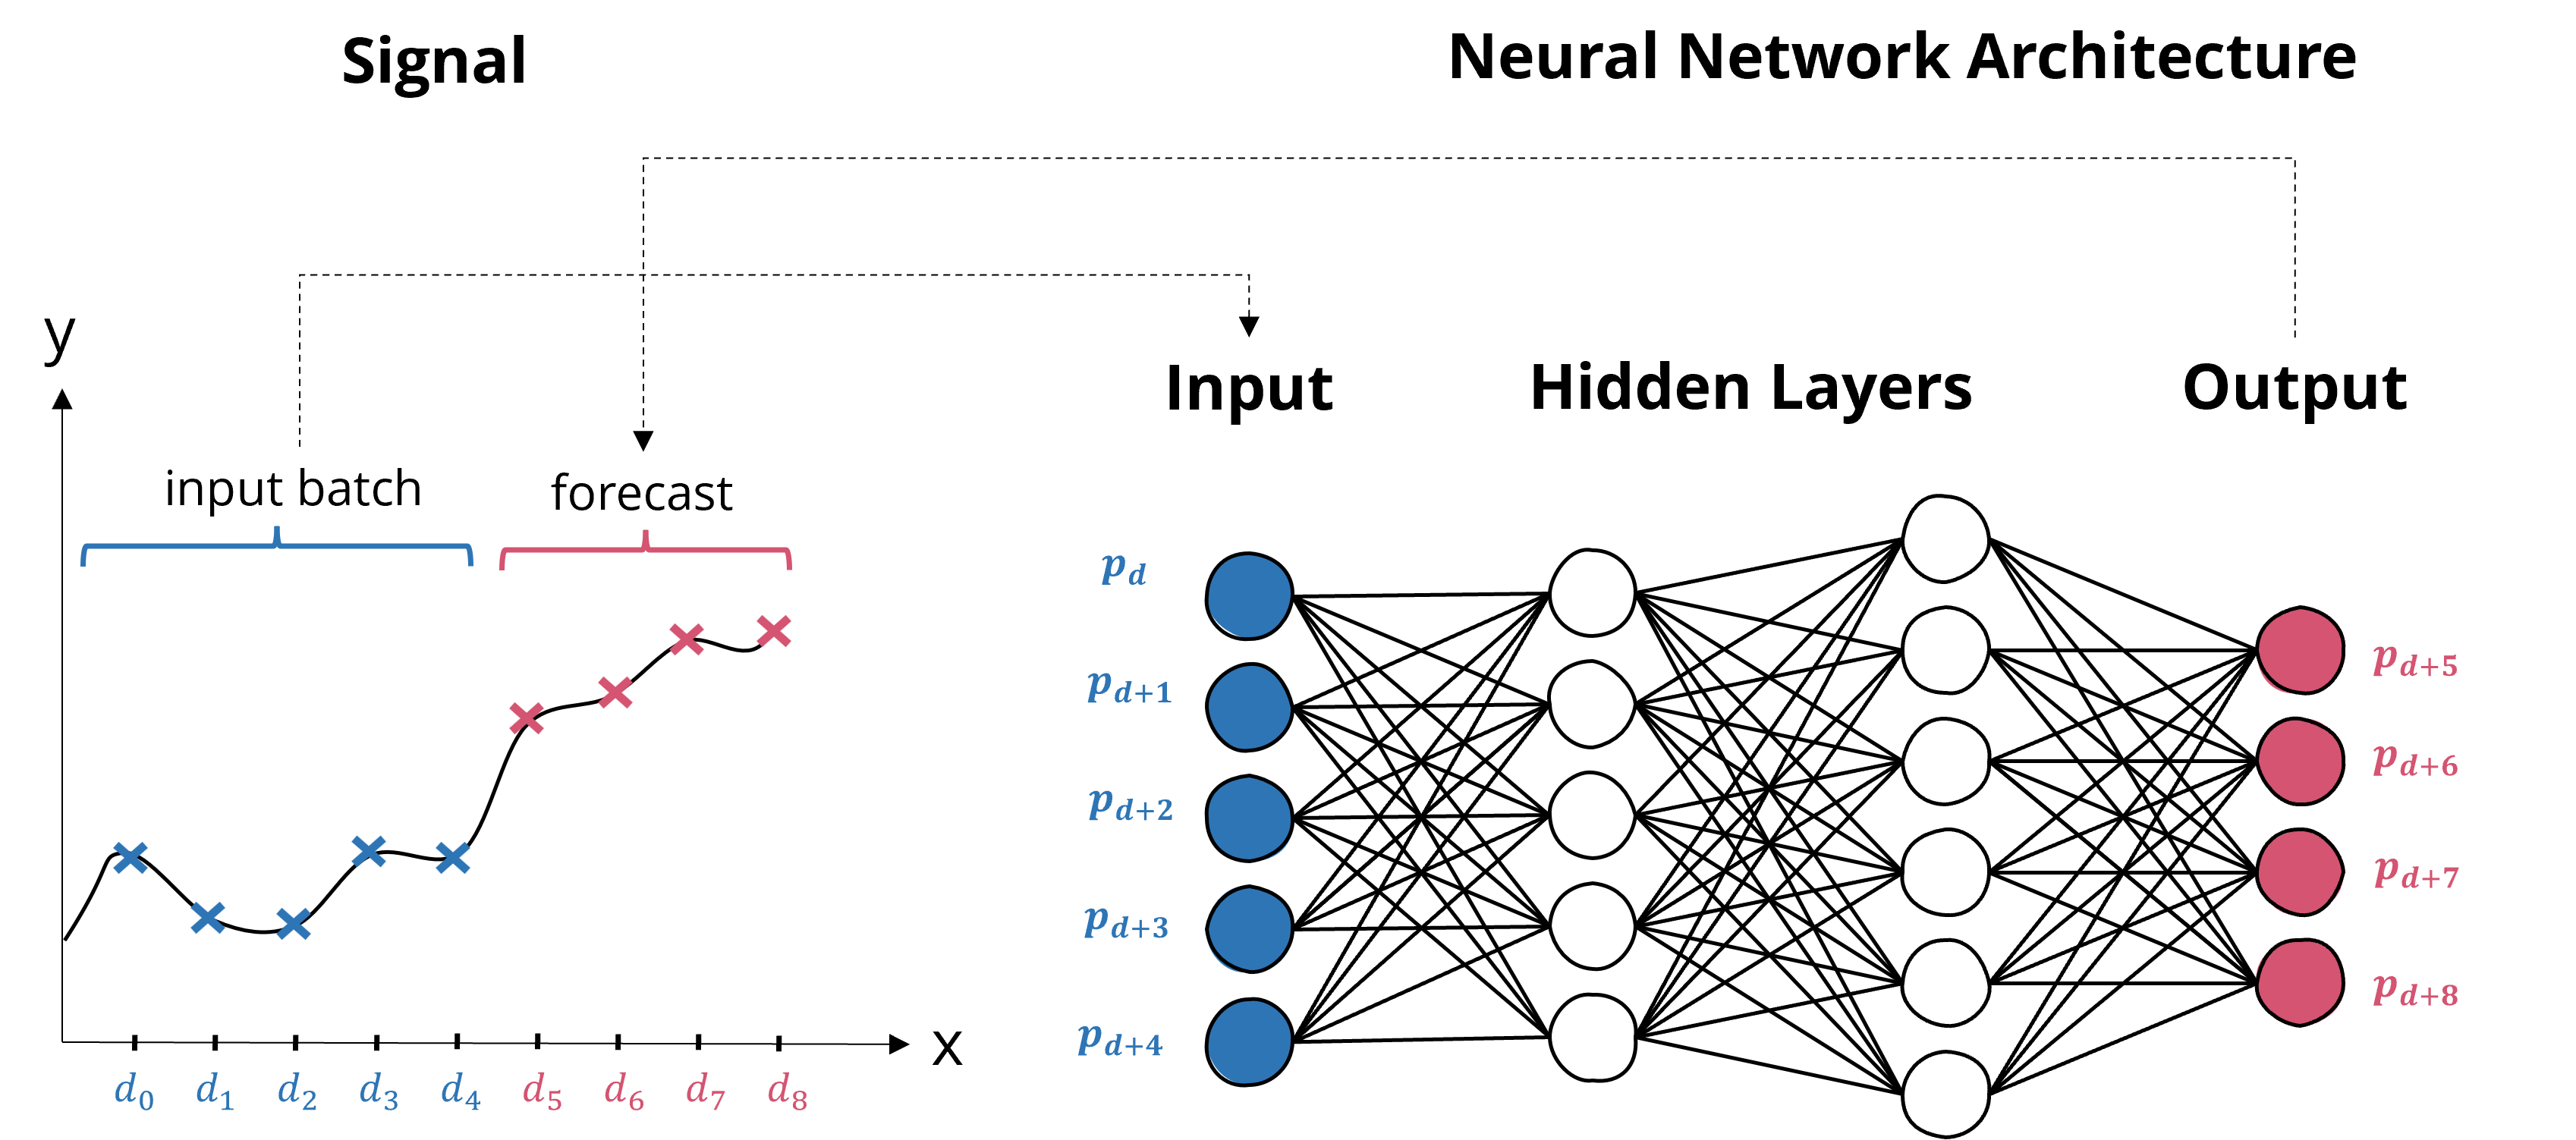The number of neurons in the first layer must match the input data, and the number of neurons in the output layer determines the period length of the predictions.


In a **multi-output regression model**, each neuron in the output layer is responsible for predicting a different time step in the future. To train such a model, *you need to provide a sequence of input data followed by the corresponding sequence of output data*. For example, if you want to predict the stock price for the next ten days, you would provide a sequence of input data containing the historical stock prices for the past 50 days, followed by a sequence of output data containing the stock prices for the next 10 days.


In [134]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np

In [135]:
config = {
    "data": {
        "window_size": 200,
        "train_split_size": 0.60,
        "validation_split_size": 0.30,  # in un secondo momento faremo la cross-validation
        "test_split_size": 0.10,

    },
    "model": {
        "input_size": 61,
        "num_lstm_layers": 1,
        "lstm_size": 200,
        "dropout": 0.3,
        "num_class": 1,
        "model_path": "Model/modelLSTMV0.pth",
        "model_name": "LSTMV0.txt",
        "save_model": True,
        "NstepsAhead": 24,
    },
    "training": {
        "device": "cuda",  # "cuda" or "cpu"
        "batch_size": 64,
        "num_epochs": 100,
        "learning_rate": 3e-4,
        "weight_decay": 0.001,
        "momentum": 0.9,
        "loss_function": nn.MSELoss(),
        "optimizer": torch.optim.Adam,
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
        "scheduler_patience": 3 ,
        "scheduler_factor": 0.5,
        "scheduler_min_lr": 1e-6,
        "early_stopping": True,
        "early_stopping_patience": 22,
        "forget_bias": 0.1,
    },
}
dataSet = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/dataSetIMRNormalized.csv")
hlc3 = dataSet['hlc3']
dataSet.drop(labels=['hlc3'], axis=1, inplace=True)
dataSet.insert(0, 'hlc3', hlc3)

# Dataloading (sliding windows)
config["model"]["input_size"] = dataSet.shape[1]  # with 1 have number of features

dataSet.shape

(52001, 61)

In [136]:
def slidingWindowsAhead(df, windowSize, nStepsAhead):
  x = []
  y = []
  dataLen = df.shape[0] # n rows
# The iteration step is now 'nStepsAhead' instead of 1.
  for i in range(windowSize, dataLen, nStepsAhead):
      if i + nStepsAhead > dataLen:
          break  # If we do not have enough data to predict further, we break the loop.
    # '_x' will contain 'windowSize' values as input data
      _x = df.iloc[i-windowSize:i].values
    # '_y' will contain 'nStepsAhead' values as labels
      _y = df.iloc[i:i+nStepsAhead, 0].values  # Select first column after row selection

      x.append(_x)
      y.append(_y)
  return np.array(x), np.array(y)

In [137]:
dfsimple = pd.DataFrame(range(31), columns=['Integer'])
dfsimple.head()

,Integer
0,0
1,1
2,2
3,3
4,4


In [138]:

simpleTrain = int(len(dfsimple) * config["data"]["train_split_size"])
simpleVal = int(len(dfsimple) * config["data"]["validation_split_size"])
simpleTest = len(dfsimple) - simpleTrain - simpleVal  # Remaining data for testing

print('_____')
trainSimpleD = dfsimple.iloc[:simpleTrain]
print(trainSimpleD)
print('_____')
valSimpleD = dfsimple.iloc[simpleTrain:simpleTrain+simpleVal]
print(valSimpleD)
print('_____')
testSimpleD = dfsimple.iloc[simpleTrain+simpleVal:]
print(testSimpleD)
print('_____')

x1, y1 = slidingWindowsAhead(trainSimpleD,5,2)
print(f"x:{x1}")
print(f"y:{y1}")
print('_____')

print("valSimpleD")
x2, y2 = slidingWindowsAhead(valSimpleD,5,2)
print(f"x:{x2}")
print(f"y:{y2}")
print('_____')

print("testSimpleD")
x3, y3 = slidingWindowsAhead(testSimpleD,5,2)
print(f"x:{x3}")
print(f"y:{y3}")
print('_____')


_____
    Integer
0         0
1         1
2         2
3         3
4         4
5         5
6         6
7         7
8         8
9         9
10       10
11       11
12       12
13       13
14       14
15       15
16       16
17       17
_____
    Integer
18       18
19       19
20       20
21       21
22       22
23       23
24       24
25       25
26       26
_____
    Integer
27       27
28       28
29       29
30       30
_____
x:[[[ 0]
  [ 1]
  [ 2]
  [ 3]
  [ 4]]

 [[ 2]
  [ 3]
  [ 4]
  [ 5]
  [ 6]]

 [[ 4]
  [ 5]
  [ 6]
  [ 7]
  [ 8]]

 [[ 6]
  [ 7]
  [ 8]
  [ 9]
  [10]]

 [[ 8]
  [ 9]
  [10]
  [11]
  [12]]

 [[10]
  [11]
  [12]
  [13]
  [14]]]
y:[[ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]
 [13 14]
 [15 16]]
_____
valSimpleD
x:[[[18]
  [19]
  [20]
  [21]
  [22]]

 [[20]
  [21]
  [22]
  [23]
  [24]]]
y:[[23 24]
 [25 26]]
_____
testSimpleD
x:[]
y:[]
_____


In [139]:
mX , mY = slidingWindowsAhead(dataSet,config["data"]["window_size"],config["model"]["NstepsAhead"])

trainWnum = int(len(mX) * config["data"]["train_split_size"])
valWnum = int(len(mX) * config["data"]["validation_split_size"])
testWnum = len(mX) - trainWnum - valWnum  # Remaining data for testing
trX = mX[:trainWnum]
valX = mX[trainWnum:trainWnum+valWnum]
testX = mX[trainWnum+valWnum:]
trY = mY[:trainWnum]
valY = mY[trainWnum:trainWnum+valWnum]
testY = mY[trainWnum+valWnum:]



print("_______ Dim mX & mY ______")
print(f"dim mX:{mX.shape} dim mY:{mY.shape}")
print("_____Dimension X & Y _____")
print(f"dim trX:{trX.shape} --- dim trY:{trY.shape} ")
print(f"dim valX:{valX.shape} --- dim valY:{valY.shape} ")
print(f"dim testX:{testX.shape} --- dim testY:{testY.shape} ")





# Convert from numpy arrays to torch tensors
trX_tensor = torch.tensor(trX, dtype=torch.float32)
trY_tensor = torch.tensor(trY, dtype=torch.float32).unsqueeze(1)
valX_tensor = torch.tensor(valX, dtype=torch.float32)
valY_tensor = torch.tensor(valY, dtype=torch.float32).unsqueeze(1)
testX_tensor = torch.tensor(testX, dtype=torch.float32)
testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1)

print("_____Dimension X & Y tensor _____")
print(f"dim trX:{trX_tensor.shape} --- dim trY:{trY_tensor.shape} ")
print(f"dim valX:{valX_tensor.shape} --- dim valY:{valY_tensor.shape} ")
print(f"dim testX:{testX_tensor.shape} --- dim testY:{testY_tensor.shape} ")


print(f"dim valX:{valX_tensor} --- dim valY:{valY_tensor} ")

_______ Dim mX & mY ______
dim mX:(2158, 200, 61) dim mY:(2158, 24)
_____Dimension X & Y _____
dim trX:(1294, 200, 61) --- dim trY:(1294, 24) 
dim valX:(647, 200, 61) --- dim valY:(647, 24) 
dim testX:(217, 200, 61) --- dim testY:(217, 24) 
_____Dimension X & Y tensor _____
dim trX:torch.Size([1294, 200, 61]) --- dim trY:torch.Size([1294, 1, 24]) 
dim valX:torch.Size([647, 200, 61]) --- dim valY:torch.Size([647, 1, 24]) 
dim testX:torch.Size([217, 200, 61]) --- dim testY:torch.Size([217, 1, 24]) 
dim valX:tensor([[[0.6733, 0.6734, 0.6724,  ..., 0.0291, 0.2549, 0.6013],
         [0.6700, 0.6722, 0.6718,  ..., 0.0291, 0.2549, 0.6013],
         [0.6691, 0.6671, 0.6701,  ..., 0.0296, 0.1039, 0.4071],
         ...,
         [0.7188, 0.7173, 0.7166,  ..., 0.0311, 0.2579, 0.4293],
         [0.7206, 0.7196, 0.7183,  ..., 0.0311, 0.2579, 0.4293],
         [0.7196, 0.7204, 0.7169,  ..., 0.0311, 0.2579, 0.4293]],

        [[0.6987, 0.6995, 0.6966,  ..., 0.0296, 0.1039, 0.4071],
         [0.7005, 

In [140]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        super(). __init__()
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]


# Create Dataset instances
train_dataset = TimeSeriesDataset(trX_tensor, trY_tensor)
val_dataset = TimeSeriesDataset(valX_tensor, valY_tensor)
test_dataset = TimeSeriesDataset(testX_tensor, testY_tensor)

# Create DataLoader instances
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config["training"]["batch_size"],
                          shuffle=False)
""" bisogna fare una prova con shffle = True e False Tuttavia, per i dati strutturati come "finestre scorrevoli" (sliding windows), dove ogni campione è indipendente e contiene le informazioni temporali necessarie nel contesto della finestra stessa, l'operazione di shuffle potrebbe non essere dannosa. In questo caso, ogni finestra agisce come un campione indipendente e il modello impara da queste finestre piuttosto che dalla sequenza complessiva """
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config["training"]["batch_size"],
                        shuffle=False)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=config["training"]["batch_size"],
                         shuffle=False)

In [141]:
class CNNLSTMModel(nn.Module):

  def __init__(self, input_size, num_lstm_layers, dropout, num_class,
               sequence_length):
    super().__init__()

    # Definizione del modello usando nn.Sequential
    self.hybridNetwork = nn.Sequential(
        nn.Conv1d(in_channels=input_size,
                  out_channels=sequence_length,
                  kernel_size=1),
        nn.ReLU(),
        nn.LSTM(input_size=sequence_length,
                hidden_size=sequence_length,
                num_layers=num_lstm_layers,
                dropout=dropout,
                batch_first=False),
    )
    self.endLinearLayer = nn.Linear(sequence_length,config["model"]["NstepsAhead"])

  def forward(self, x):
    # Apply CNN layers
    x = x.permute(0, 2, 1)
    x = self.hybridNetwork[0](x)  # Conv1d
    x = self.hybridNetwork[1](x)  # ELU activation

    # Permute the dimensions for LSTM
    x = x.permute(2, 0, 1)

    # Apply LSTM layers
    x, (hidden, cell) = self.hybridNetwork[2](x)

    # Only take the output from the last time-step
    x = x[-1, :, :]

    # Apply final linear layer
    x = self.endLinearLayer(x)
    return x




In [142]:
hybridModelCNNLSTML1L2_24h = CNNLSTMModel(
    input_size=61,
    num_lstm_layers=config["model"]["num_lstm_layers"],
    dropout=config["model"]["dropout"],
    num_class=1,
    sequence_length=config["data"]["window_size"])
print(hybridModelCNNLSTML1L2_24h)
hybridModelCNNLSTML1L2_24h.to(config["training"]["device"])

# Parameters for regularization
l1_regularization = True
l1_factor = 1e-5
train_hist = []
val_hist = []
test_hist = []
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(hybridModelCNNLSTML1L2_24h.parameters(),
                             lr=config["training"]["learning_rate"],weight_decay=config["training"]["weight_decay"]) # L2 reg

scheduler = config["training"]["scheduler"](
    optimizer,
    patience=config["training"]["scheduler_patience"],
    factor=config["training"]["scheduler_factor"],
    min_lr=config["training"]["scheduler_min_lr"])
best_val_loss = float('inf')
patience_counter = 0
loss_list = []
test_loss_list = []
# of accuracy for a regression model, with bootstrapping 95% of confident predictions


CNNLSTMModel(
  (hybridNetwork): Sequential(
    (0): Conv1d(61, 200, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): LSTM(200, 200, dropout=0.3)
  )
  (endLinearLayer): Linear(in_features=200, out_features=24, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [143]:
def trainLoop(model, train_loader, optimizer, scheduler, loss_fn):
  model.train()
  train_loss = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(config["training"]["device"]), target.to(
        config["training"]["device"])
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    if l1_regularization:
      # Manually add L1 regularization term
      l1_penalty = sum(p.abs().sum() for p in model.parameters()) * l1_factor
      loss += l1_penalty
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  avg_loss = train_loss / len(train_loader)
  print(f"Train loss: {avg_loss}")
  return train_loss, avg_loss


def valLoop(model, val_loader, loss_fn):
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_loader):
      data, target = data.to(config["training"]["device"]), target.to(
          config["training"]["device"])
      output = model(data)
      loss = loss_fn(output, target)
      val_loss += loss.item()
  avg_loss = val_loss / len(val_loader)
  print(f"Validation loss: {avg_loss}")
  return val_loss, avg_loss


def testLoop(model, test_loader, loss_fn):
  model.eval()
  test_loss = 0
  all_predictions = []
  all_targets = []
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(config["training"]["device"]), target.to(
          config["training"]["device"])
      output = model(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()

      all_predictions.extend(
          output.squeeze().tolist())  # Flatten and accumulate predictions
      all_targets.extend(
          target.squeeze().tolist())  # Flatten and accumulate actual values

      # Calculate metrics
  mse = mean_squared_error(all_targets, all_predictions)
  print(f"Test  MSE:{mse} ")
  MAE = mean_absolute_error(all_targets, all_predictions)
  print(f'Test Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(all_targets, all_predictions)/ all_targets))) * 100
  print(f'Test Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(all_targets, all_predictions)/ all_targets)) ) * 100
  print(f'Test Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
  mse = mean_squared_error(all_targets, all_predictions)
  rmse = mean_squared_error(all_targets, all_predictions, squared=False)
  mae = mean_absolute_error(all_targets, all_predictions)
  r2 = r2_score(all_targets, all_predictions)
  test_loss /= len(test_loader.dataset)
  return all_predictions,all_targets,test_loss, mse, rmse, mae, r2,MAE,MAPE,MDAPE


def testLoop2(model, test_loader, loss_fn,scaler):
  model.eval()
  test_loss = 0
  i = 0
  all_predictions = []
  all_targets = []
  metrics1 = pd.DataFrame({
    "batch_idx": [],
    "loss": [],
    "MAE": [],
    "MSE": [],
    "MAPE": [],
    "MDAPE": []
})

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(config["training"]["device"]), target.to(
          config["training"]["device"])
      output = model(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()
      test_loss /= len(test_loader.dataset)


      data_predict = output.detach().cpu().numpy()
      print("Dimensione di data_predict:", data_predict.shape)

      dataY_plot = target.detach().cpu().numpy()



      # Calcolo delle metriche di performance sui valori
      mse = mean_squared_error(dataY_plot, data_predict)
      MAE = mean_absolute_error(dataY_plot, data_predict)
      MAPE = np.mean((np.abs(np.subtract(dataY_plot, data_predict)/ dataY_plot))) * 100
      # Median Absolute Percentage Error (MDAPE)
      MDAPE = np.median((np.abs(np.subtract(dataY_plot, data_predict)/ dataY_plot)) ) * 100
      print(f"_________________________________________________ \n")
      print(f"batch_idx:{batch_idx} metrics:")
      print(f'Mean Absolute Percentage Error (mse): {np.round(mse, 2)} %')
      print(f'Mean Absolute Percentage Error (MAE): {np.round(MAE, 2)} %')
      print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
      print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')


      all_predictions.extend(
          output.squeeze().tolist())  # Flatten and accumulate predictions
      all_targets.extend(
          target.squeeze().tolist())  # Flatten and accumulate actual values
      i += 1
      metrics1.iloc[i] = [batch_idx, loss.item(), MAE, mse, MAPE, MDAPE]

      # ora si plotta
      x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(data, target, data_predict)
      title = f"Predictions vs y_test - test batch number {batch_idx}"
      plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title)

  return all_predictions,all_targets,test_loss,metrics1



In [144]:
# funzioni di plot di servizio
def prepare_df(x, y, y_pred_unscaled,scaler):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler.inverse_transform(x)[:,0]).rename(columns={0:'x_test'})
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler.inverse_transform(y)).rename(columns={0:'y_test'})
    y_pred_df = pd.DataFrame(y_pred_unscaled).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df







In [145]:
# epoch loop
for epoch in range(config["training"]["num_epochs"]):
    val_loss, avg_loss = trainLoop(hybridModelCNNLSTML1L2_24h, train_loader, optimizer, scheduler, loss_fn)
    val_loss, avg_val_loss = valLoop(hybridModelCNNLSTML1L2_24h, val_loader, loss_fn)
    train_hist.append(avg_loss)
    val_hist.append(avg_val_loss)
    print(f"Epoch: {epoch} train loss: {avg_loss} val loss: {avg_val_loss} \n")


    # Controllare il salvataggio del miglior modello per l'epoca corrente
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0


    else:
        patience_counter += 1
    # Controllare l'early stopping
    if patience_counter > config["training"]["early_stopping_patience"]:
        print("Early stopping triggered.")
        break
    # Aggiornamento dello scheduler, se usato
    scheduler.step(val_loss)

# model performance evalutation

all_predictions,all_targets,test_loss, mse, rmse, mae, r2,MAE,MAPE,MDAPE = testLoop(hybridModelCNNLSTML1L2_24h, test_loader, loss_fn)

# test_loss, mse, rmse, mae, r2 = testLoop(HybridModelV1, test_loader, loss_fn)
print(f"Test Loss: {test_loss:.10f}")
print(f"MSE: {mse:.10f}")
print(f"RMSE: {rmse:.10f}")
print(f"MAE: {mae:.10f}")
print(f"R^2: {r2:.10f}")
print(f"MAE:{MAE:.10f}")
print(f"MAPE:{MAPE:.10f}")
print(f"MDAPE:{MDAPE:.10f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 24])) that is different to the input size (torch.Size([64, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14, 1, 24])) that is different to the input size (torch.Size([14, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([7, 1, 24])) that is different to the input size (torch.Size([7, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  re

Train loss: 0.18407338857650757
Validation loss: 0.11446482324126092
Epoch: 0 train loss: 0.18407338857650757 val loss: 0.11446482324126092 

Train loss: 0.13949503820566905
Validation loss: 0.04527923517691141
Epoch: 1 train loss: 0.13949503820566905 val loss: 0.04527923517691141 

Train loss: 0.1087870839096251
Validation loss: 0.011359307618642395
Epoch: 2 train loss: 0.1087870839096251 val loss: 0.011359307618642395 

Train loss: 0.08661987384160359
Validation loss: 0.011406036390160973
Epoch: 3 train loss: 0.08661987384160359 val loss: 0.011406036390160973 

Train loss: 0.07958149342309861
Validation loss: 0.0069869419385213405
Epoch: 4 train loss: 0.07958149342309861 val loss: 0.0069869419385213405 

Train loss: 0.07070690074137279
Validation loss: 0.009929167720573869
Epoch: 5 train loss: 0.07070690074137279 val loss: 0.009929167720573869 

Train loss: 0.06902276813274338
Validation loss: 0.01174067837101492
Epoch: 6 train loss: 0.06902276813274338 val loss: 0.01174067837101492 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25, 1, 24])) that is different to the input size (torch.Size([25, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 dim all targets & all predictions
all_predictions:24 
 all_targets: 24 
windows 0 MSE:0.00016398145267012185 
W: 0 Median Absolute Error (MAE): 0.01
W: 0 Mean Absolute Percentage Error (MAPE): 3.48 %
W: 0 Median Absolute Percentage Error (MDAPE): 3.45 %


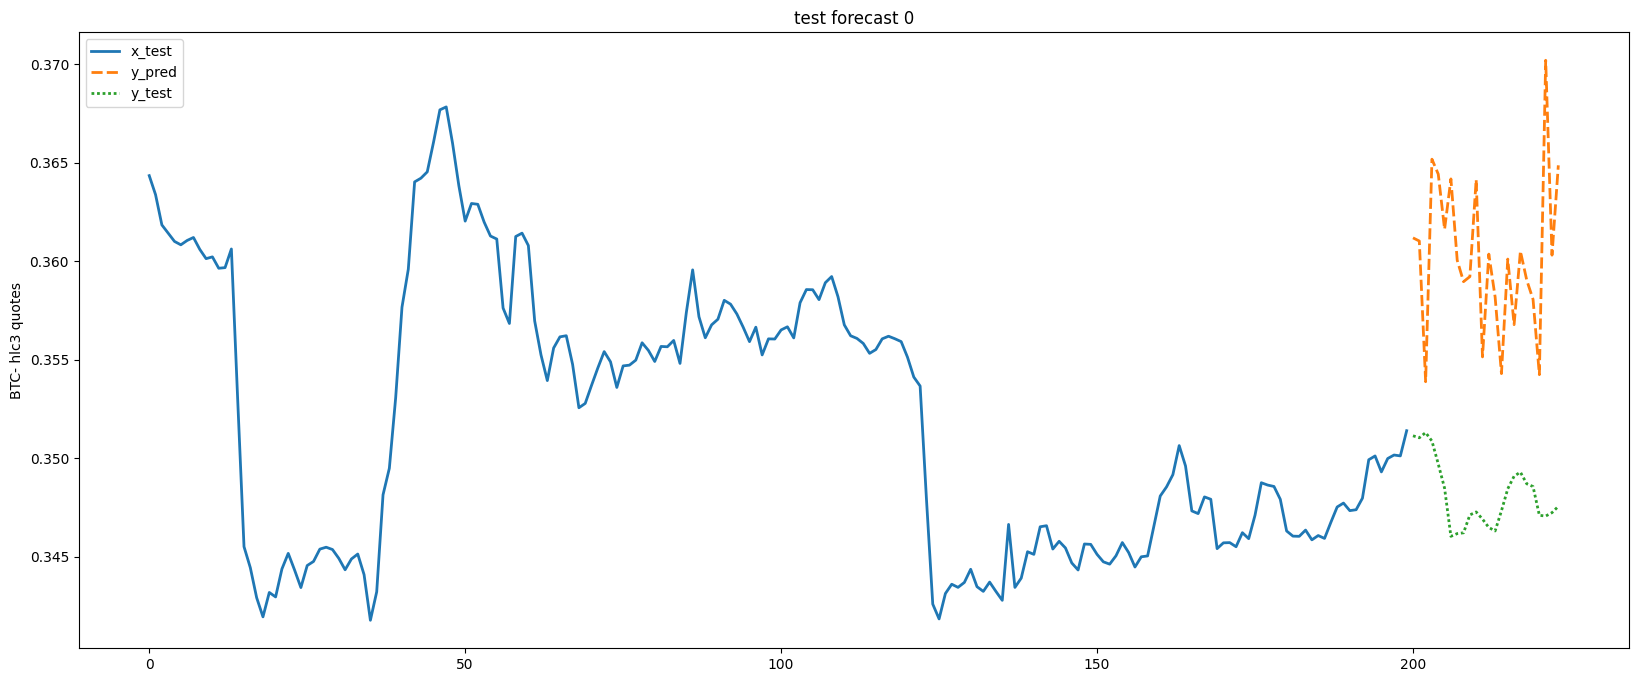

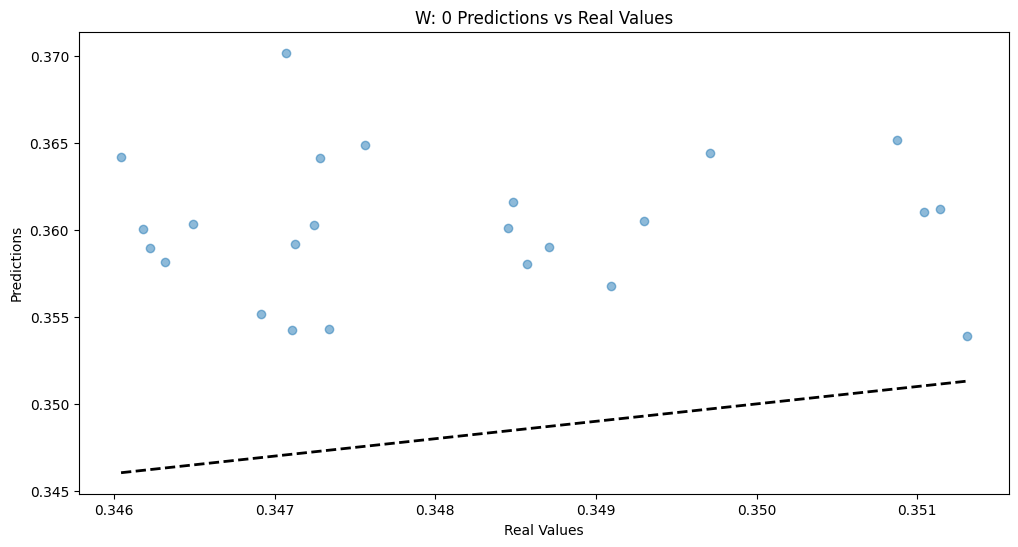

windows 1 MSE:0.0004130757338075182 
W: 1 Median Absolute Error (MAE): 0.02
W: 1 Mean Absolute Percentage Error (MAPE): 5.57 %
W: 1 Median Absolute Percentage Error (MDAPE): 6.27 %


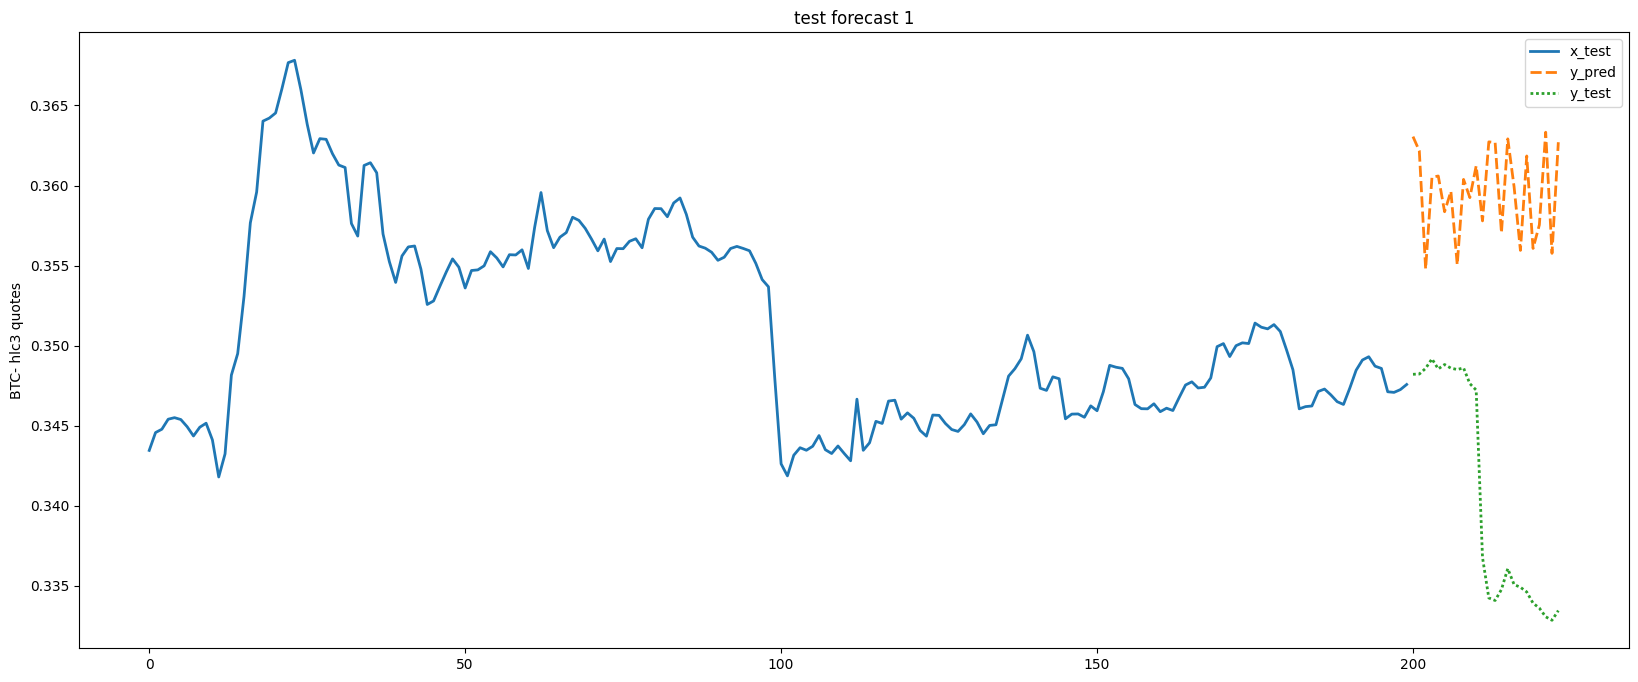

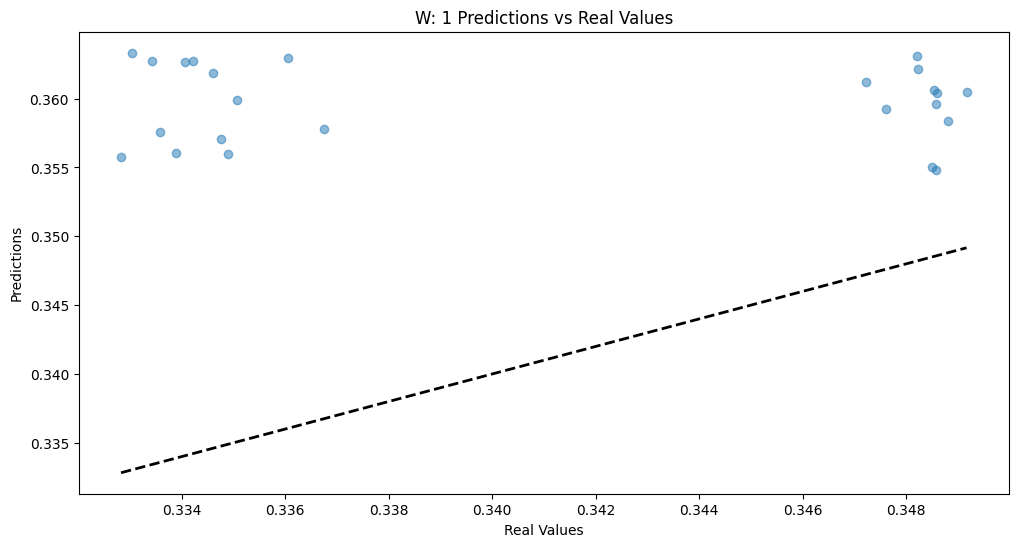

windows 2 MSE:0.00026310249783171685 
W: 2 Median Absolute Error (MAE): 0.02
W: 2 Mean Absolute Percentage Error (MAPE): 4.53 %
W: 2 Median Absolute Percentage Error (MDAPE): 4.75 %


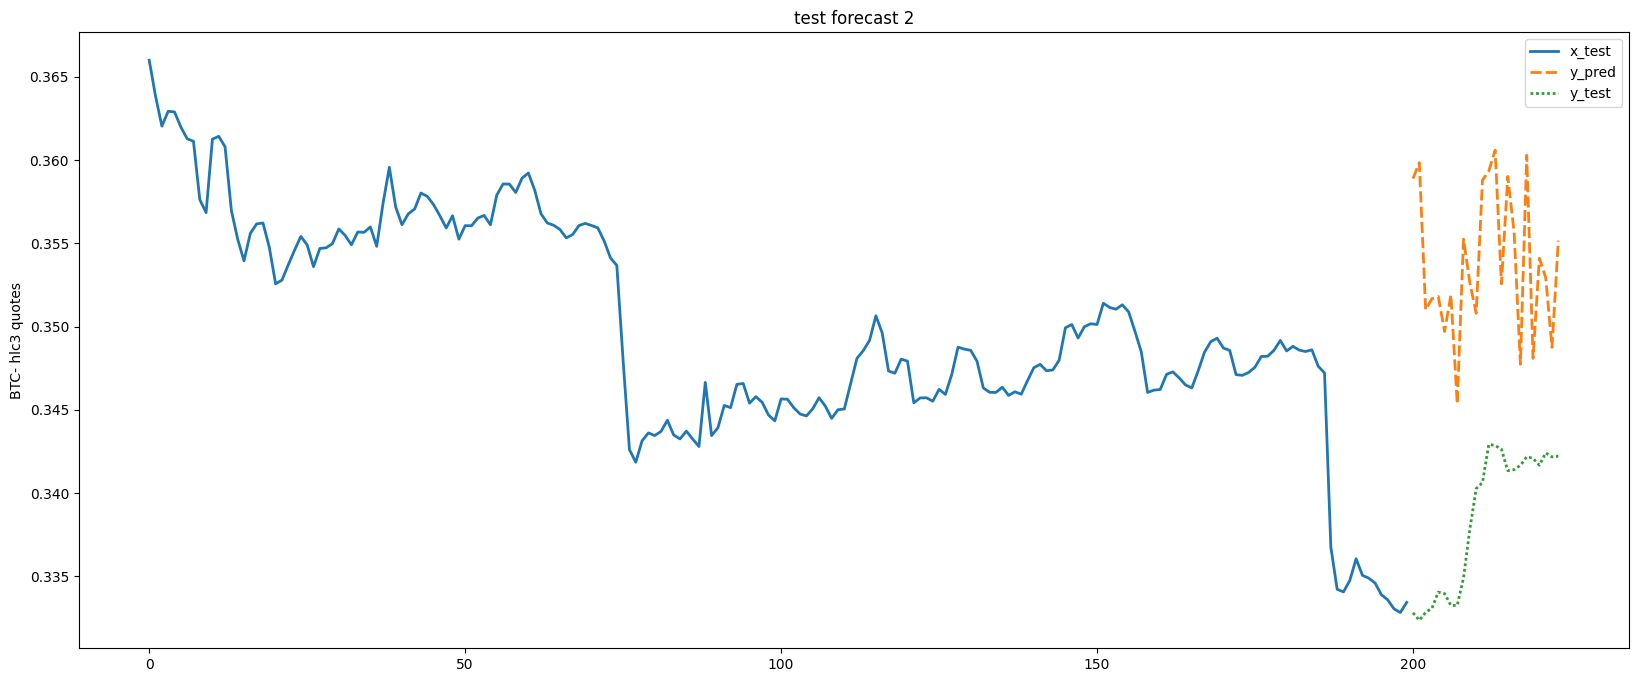

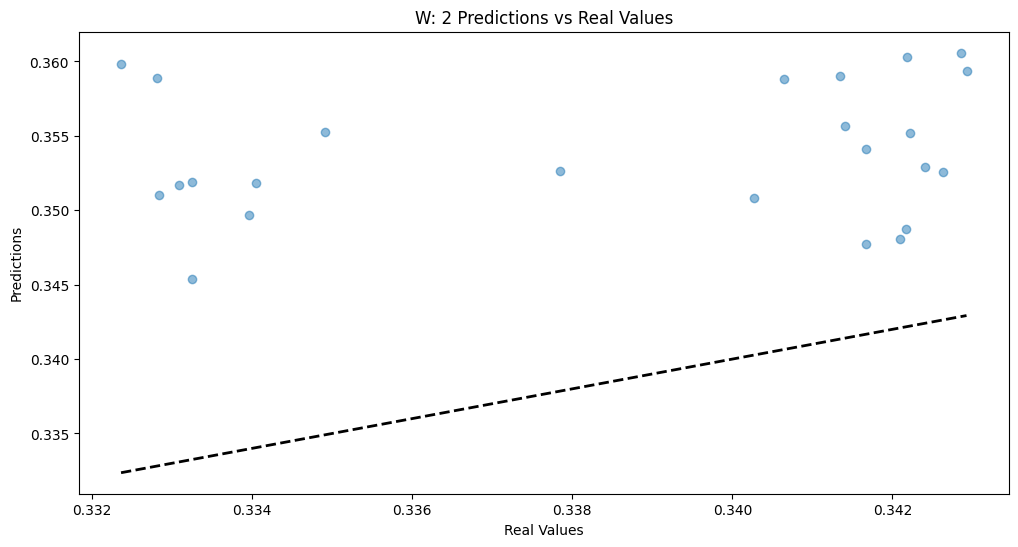

In [146]:
def prepare_df1(x, y, y_pred):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame({'x_test': x[:, 0]})
    y_test_unscaled_df = pd.DataFrame({'y_test': y})
    y_pred_df = pd.DataFrame({'y_pred': y_pred})

    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df



def plot_multi_test_forecast(x_test, y_test, y_pred, title):
    # Create DataFrames for x_test, y_pred, and y_test
    df_merge = y_pred.join(y_test, how='left')
    df_merge1 = pd.concat([x_test, df_merge]).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel =  "BTC- hlc3 quotes")
    sns.lineplot(data = df_merge1, linewidth=2.0, ax=ax)







print(f" dim all targets & all predictions")
print(f"all_predictions:{len(all_predictions[1])} \n all_targets: {len(all_targets[1])} ")
for i in range(3):
  x_test, y_pred, y_test =prepare_df1(testX[i], all_targets[i], all_predictions[i])
  title = f"test forecast {i}"
  plot_multi_test_forecast(x_test, y_test, y_pred, title)
  mse = mean_squared_error(all_targets[i], all_predictions[i])
  print(f"windows {i} MSE:{mse} ")
  MAE = mean_absolute_error(all_targets[i], all_predictions[i])
  print(f'W: {i} Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(all_targets[i], all_predictions[i])/ all_targets[i]))) * 100
  print(f'W: {i} Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(all_targets[i], all_predictions[i])/ all_targets[i])) ) * 100
  print(f'W: {i} Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

  plt.figure(figsize=(12, 6))
  plt.scatter(all_targets[i], all_predictions[i], alpha=0.5)
  plt.title(f'W: {i} Predictions vs Real Values')
  plt.xlabel('Real Values')
  plt.ylabel('Predictions')
  plt.plot([min(all_targets[i]), max(all_targets[i])], [min(all_targets[i]), max(all_targets[i])], 'k--', lw=2)
  plt.show()



In [152]:
model_filename = "/content/drive/MyDrive/Colab Notebooks/Model-PTH/hybridCNNLSTM24h_L1L2Verified_epoch_{}_loss_{:.4f}.pth".format(epoch, best_val_loss)
torch.save(hybridModelCNNLSTML1L2_24h.state_dict(), model_filename)
print(f'Model saved as {model_filename}')

Model saved as /content/drive/MyDrive/Colab Notebooks/Model-PTH/hybridCNNLSTM24h_L1L2Verified_epoch_54_loss_0.0664.pth


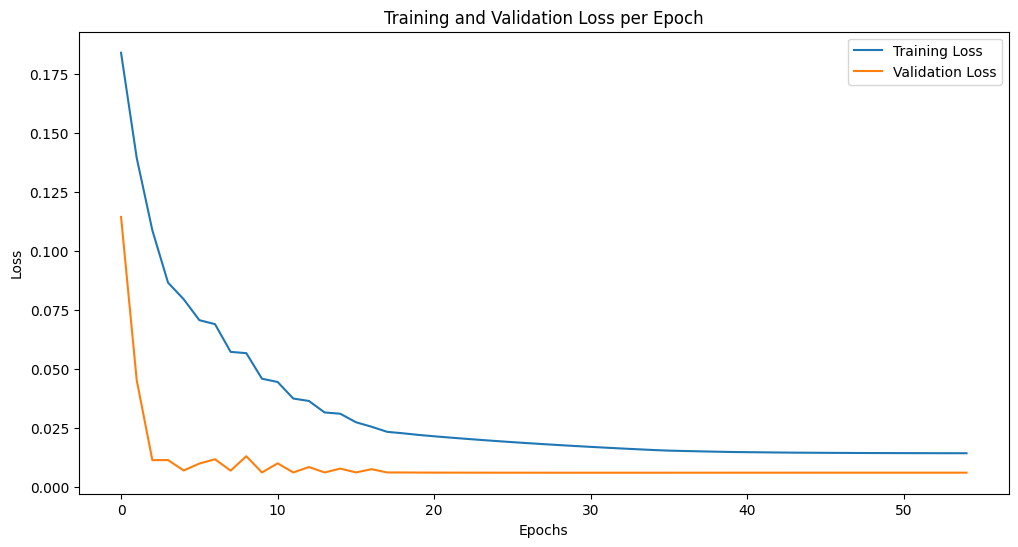

In [148]:
import matplotlib.pyplot as plt



# Grafico di training e validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_hist, label='Training Loss')
plt.plot(val_hist, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

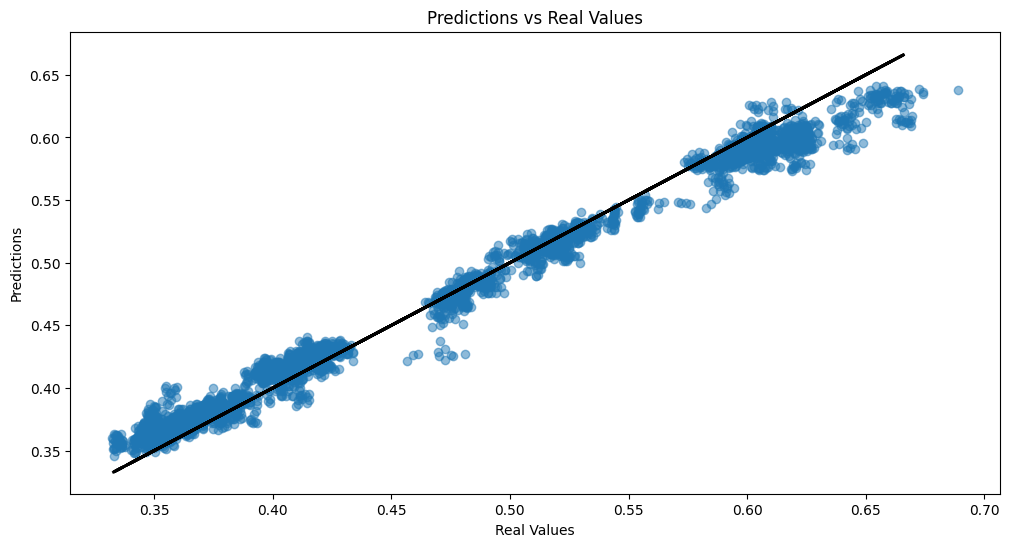

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(all_targets, all_predictions, alpha=0.5)
plt.title('Predictions vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'k--', lw=2) # Linea y=x per riferimento
plt.show()

In [150]:
# now i take my model and computer some other metrics and i will do unscaling op and i will plot some usefull charts
import joblib
scalerPath = "/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/scaler.pkl"
scaler = joblib.load(scalerPath)
all_predictions,all_targets,test_loss,metrics1 = testLoop2(hybridModelCNNLSTML1L2_24h, test_loader,loss_fn,scaler)


# now we do other forecast




FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/scaler.pkl'